## Testing "tripolate()" manual triangular interpolation

In [1]:
using Plots; pyplot()

Plots.PyPlotBackend()

In [180]:
function tripolate(V, x, y)
    # Triangular (linear) interpolation:
    # 0<=|x|<=1, 0<=|y|<=1 and N parition points
    # of [0,1] for x, y
    N  = size(V, 1)-1
    xf = Int(floor(N*x) - floor(x))
    yf = Int(floor(N*y) - floor(y))
    x_ = (N*x - xf)
    y_ = (N*y - yf)
    if min(xf, yf) == 0 && max(xf, yf) <= 1
        x_ = 1-x_
        y_ = 1-y_
    end
    if xf + yf <= 1
        return V[xf+2,yf+1]*(1-x_) + V[xf+1,yf+2]*(1-y_) - V[xf+1,yf+1]*(1-x_-y_)
    else
        return V[xf+2,yf+1]*(x_) + V[xf+1,yf+2]*(y_) + V[xf+1,yf+1]*(1-x_-y_)
    end 
end

tripolate (generic function with 1 method)

In [9]:
function interpV_tri(simplex, V)
    N_simplex = Int((sqrt(8*size(simplex, 1)+1)-1)/2)
    augment_V = zeros(N_simplex, N_simplex)
    k = 1
    for i in 1:N_simplex
        for j in 1:(N_simplex+1-i)
            augment_V[i,j] = V[k]
            k += 1
        end
    end

    interpolate_V(x) = tripolate(augment_V, x[1], x[2])

    return interpolate_V
end

interpV_tri (generic function with 1 method)

In [4]:
using GridInterpolations

function interpV(simplex, V)

    step = simplex[2,2]
    grid = 0.0:step:1.0
    size_simplex = length(grid)

    augment_V = zeros(size_simplex, size_simplex)
    k = 1
    for i in 1:size_simplex
        for j in 1:size_simplex
            if j <= size_simplex+1-i
                augment_V[i,j] = V[k]
                k += 1
            end
        end
    end

    interpolate_V(x) = interpolate(SimplexGrid(grid, grid), flipdim(augment_V,1), [1-x[1], x[2]])

    return interpolate_V

end

interpV (generic function with 1 method)

In [5]:
function generate_simplex_3dims(n_per_dim::Integer=20) 

    simplex = [[x, y, 1-x-y] for x in linspace(0,1,n_per_dim) for y in linspace(0,1,n_per_dim) if x+y <= 1.0]

    return hcat(simplex...)'

end
                
# Generate a test simplex:
test_simplex = generate_simplex_3dims()

210×3 Array{Float64,2}:
 0.0       0.0        1.0        
 0.0       0.0526316  0.947368   
 0.0       0.105263   0.894737   
 0.0       0.157895   0.842105   
 0.0       0.210526   0.789474   
 0.0       0.263158   0.736842   
 0.0       0.315789   0.684211   
 0.0       0.368421   0.631579   
 0.0       0.421053   0.578947   
 0.0       0.473684   0.526316   
 0.0       0.526316   0.473684   
 0.0       0.578947   0.421053   
 0.0       0.631579   0.368421   
 ⋮                               
 0.789474  0.157895   0.0526316  
 0.789474  0.210526   0.0        
 0.842105  0.0        0.157895   
 0.842105  0.0526316  0.105263   
 0.842105  0.105263   0.0526316  
 0.842105  0.157895   5.55112e-17
 0.894737  0.0        0.105263   
 0.894737  0.0526316  0.0526316  
 0.894737  0.105263   0.0        
 0.947368  0.0        0.0526316  
 0.947368  0.0526316  5.55112e-17
 1.0       0.0        0.0        

In [6]:
# Create a test function:
f(x) = exp(-(3*(x[1])^2+(3*x[2])^2))

F = zeros(size(test_simplex,1),1)

for j in 1:length(F)
    F[j] = f(test_simplex[j,:])
end

(0.009744525326989495, 2653)


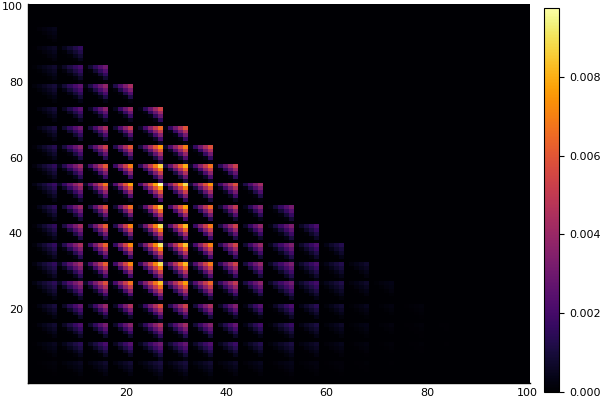

In [181]:
interpF = interpV(test_simplex, F)

X = linspace(0, 1, 100)
Y = linspace(0, 1, 100)

Vplot = zeros(length(X), length(Y))

for (i, x) in enumerate(X)
    for j in 1:(length(X)-i+1)
        Vplot[i, j] = interpF([x, Y[j], 1-(x+Y[j])])
    end
end

#surface(Vplot, color = :plasma)

interpF_tri = interpV_tri(test_simplex, F)

Vplot_tri = zeros(length(X), length(Y))

for (i, x) in enumerate(X)
    for j in 1:(length(X)-i+1)
        Vplot_tri[i, j] = interpF_tri([x, Y[j], 1-(x+Y[j])])
    end
end

#surface(Vplot_tri, color = :plasma)
println(findmax(abs.(Vplot - Vplot_tri)))
heatmap((Vplot - Vplot_tri))